# Проект "Анализ успешности компьютерных игр в интернет-магазине 'Стримчик'"

В рамках данного исследовательского проекта мы проведем анализ исторических данных по продажам компьютерных игр в интернет-магазине "Стримчик". Наша цель - выявить закономерности, определяющие успешность игр, и предоставить основанные на данных рекомендации для планирования рекламных кампаний и выбора потенциально популярных продуктов.

#### Шаг 1. Откройте файл с данными и изучите общую информацию

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
!pip install missingno
import missingno as msno

In [14]:
games = pd.read_csv('/datasets/games.csv')
# выводим общую информацию о данных
print(games.info())
# выводим первые строки датасета
print(games.head())
# проверяем на наличие пропущенных значений
print(games.isnull().sum())
# проверяем на наличие дубликатов
print(games.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None
                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29

Смотря на наш вывод мы видим, что столбец Name и Genre имеет по 2 пропущенных значения, Year_of_Release имеет 269 пропущенных значений, столбцы Critic_Score, User_Score, Rating содержат существенное количество пропущенных значений. И дубликатов не обнаружено.

<AxesSubplot:>

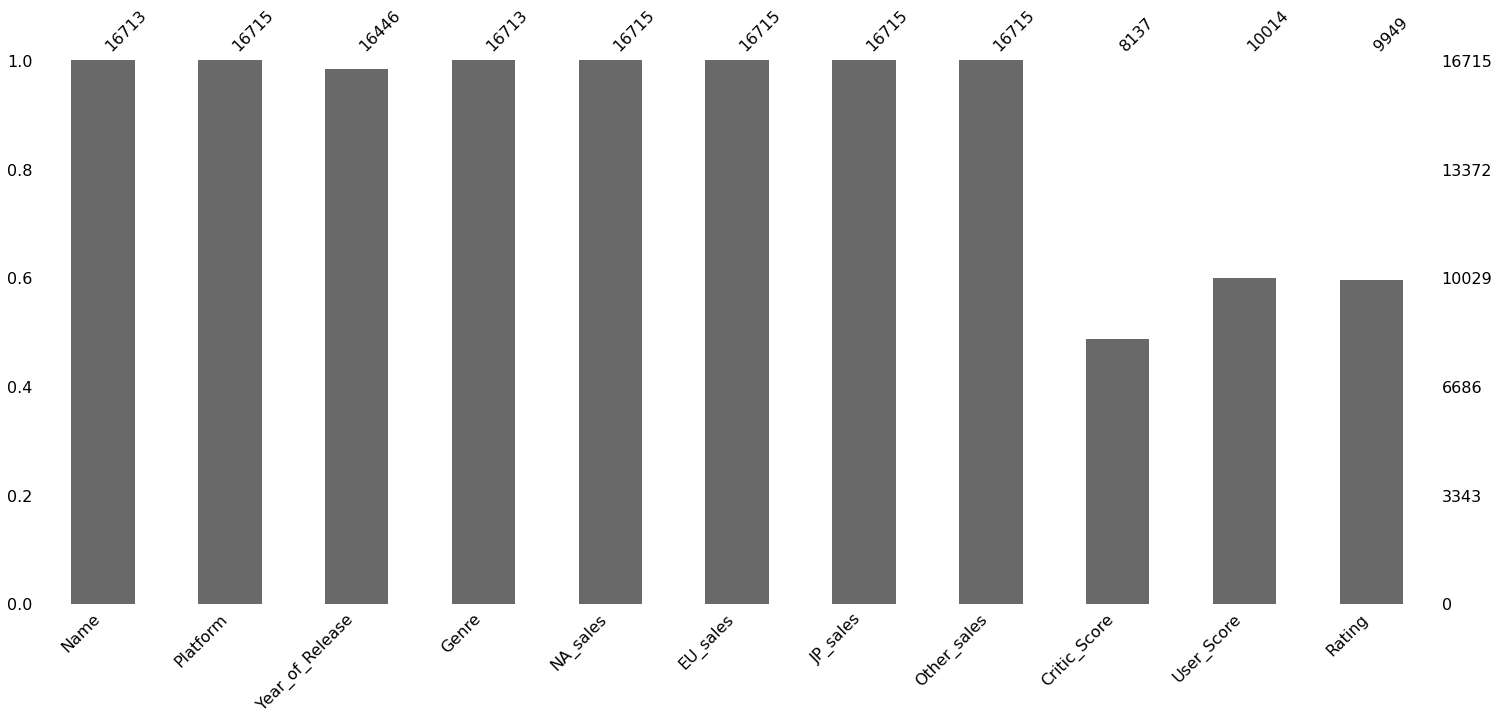

In [15]:
msno.bar(games)

In [16]:
games.columns = games.columns.str.lower()
# Вывод строк с пропущенными значениями в столбцах 'name' или 'genre'
missing_name_genre = games[games['name'].isnull() | games['genre'].isnull()]
print(missing_name_genre)


      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  


#### Шаг 2. Подготовьте данные

In [4]:
# приводим названия столбцов к нижнему регистру
#games.columns = games.columns.str.lower()
# преобразуем данные в нужные типы
#games['year_of_release'] = games['year_of_release'].astype('Int64')
# обработаем 'tbd' в столбце user_score
#games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')
# удаляем строки с пропущенными значениями в name и genre
#games = games.dropna(subset=['name', 'genre'])
# делаем замену 'tbd' на NaN в столбце user_score
#games['user_score'].replace('tbd', pd.NA, inplace=True)
# создаем столбец с суммарными продажами во всех регионах
#games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']


In [17]:
# приводим названия столбцов к нижнему регистру
games.columns = games.columns.str.lower()
# преобразуем данные в нужные типы
games['year_of_release'] = games['year_of_release'].astype('Int32')  
# обработаем 'tbd' в столбце user_score
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')
# удаляем строки с пропущенными значениями в name и genre
games = games.dropna(subset=['name', 'genre'])
# делаем замену 'tbd' на NaN в столбце user_score
games['user_score'].replace('tbd', pd.NA, inplace=True)
# создаем столбец с суммарными продажами во всех регионах
games['total_sales'] = games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

Для столбцов critic_score и user_score пропущенные значения заполнять не будем, так как оценки критиков и пользователей могут быть важными факторами, и заполнение их средними значениями может повлиять на результаты.
Столбцы name и genre имеют всего по два пропущенных значения, их можно удалить без больших потерь.
Пропущенные значения в year_of_release оставим, так как год выпуска может быть важен для анализа, и заполнение средними значениями может исказить данные. 'tbd' означает "будет определено", и скорее всего, эти игры еще не получили достаточного количества оценок, поэтому аменим 'tbd' на NaN, чтобы не исказить анализ.

#### Шаг 3. Проведите исследовательский анализ данных

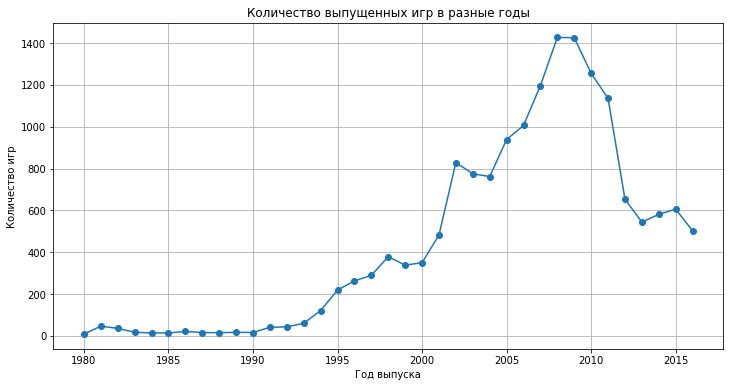

In [5]:
# посмотрим сколько игр выпускалось в разные годы
games_per_year = games.groupby('year_of_release')['name'].count()

# визуализируем
games_per_year.plot(kind='line', marker='o', linestyle='-', figsize=(12, 6), grid=True)
plt.title('Количество выпущенных игр в разные годы')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.show()

Самое большое количество игр 1400 было выпущено 2008 году. Судя по графику для прогноза на 2017 год важны не все данные за все периоды.

Сначала подсчитываем суммарные продажи по каждой платформе, потом берем топ платформы (в нашем случае DS, PS2, PS3, Wii, X360) с наибольшими суммарными продажами, фильтруем данные по этим платформам и строим график распределения продаж по годам для выбранных платформ.

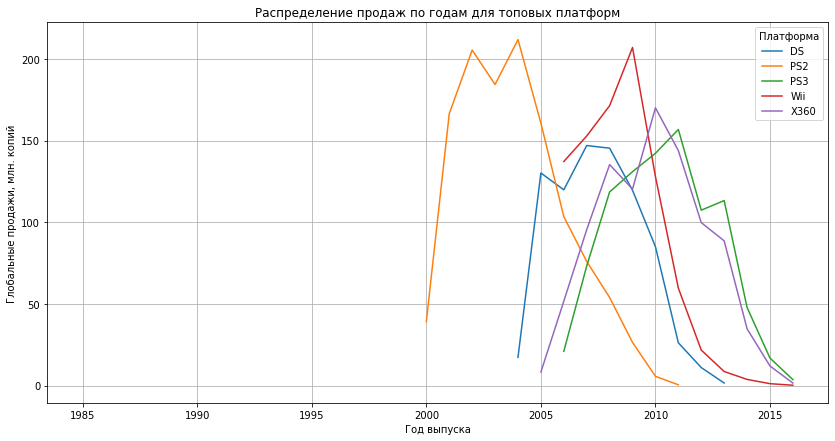

In [41]:
# посмотрим как менялись продажи по платформам
#platform_year_sales = games.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

# выбираем топовые платформы
#top_platforms = platform_year_sales.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index
#top_platforms_data = platform_year_sales[platform_year_sales['platform'].isin(top_platforms)]

# визуализируем 
#platform_year_sales[platform_year_sales['platform'].isin(top_platforms)] \
#   .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum') \
#   .plot(kind='line', figsize=(14, 7), grid=True)

#plt.title('Распределение продаж по годам для топовых платформ')
#plt.xlabel('Год выпуска')
#plt.ylabel('Глобальные продажи, млн. копий')
#plt.legend(title='Платформа'
#plt.show()

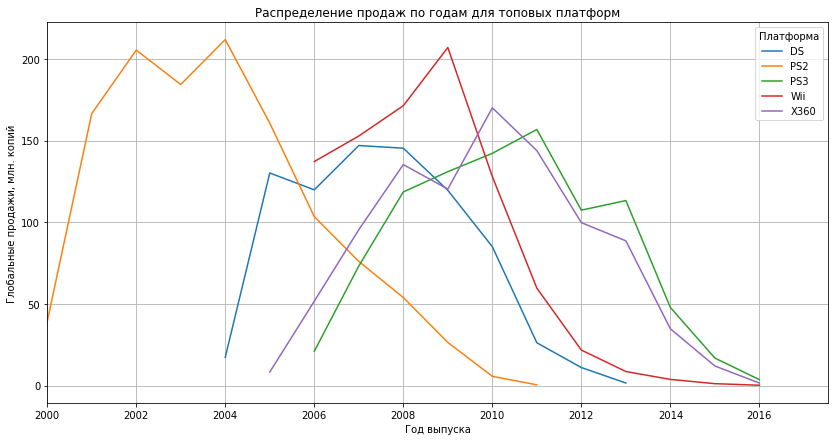

In [18]:
# посмотрим как менялись продажи по платформам
platform_year_sales = games.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

# выбираем топовые платформы
top_platforms = platform_year_sales.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index
top_platforms_data = platform_year_sales[platform_year_sales['platform'].isin(top_platforms)]

# визуализируем 
ax = platform_year_sales[platform_year_sales['platform'].isin(top_platforms)] \
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum') \
    .plot(kind='line', figsize=(14, 7), grid=True)

plt.title('Распределение продаж по годам для топовых платформ')
plt.xlabel('Год выпуска')
plt.ylabel('Глобальные продажи, млн. копий')
plt.legend(title='Платформа')

# ограничим график по оси x до 2000 года
plt.xlim(2000)
plt.show()

In [7]:
# определяем актуальный период
#latest_years = games['year_of_release'].max()
#start_year = latest_years - 5
#actual_data = games[games['year_of_release'] >= start_year]

In [24]:
# определяем актуальный период
latest_years = games['year_of_release'].max()
start_year = latest_years - 2
actual_data = games[games['year_of_release'] >= start_year]

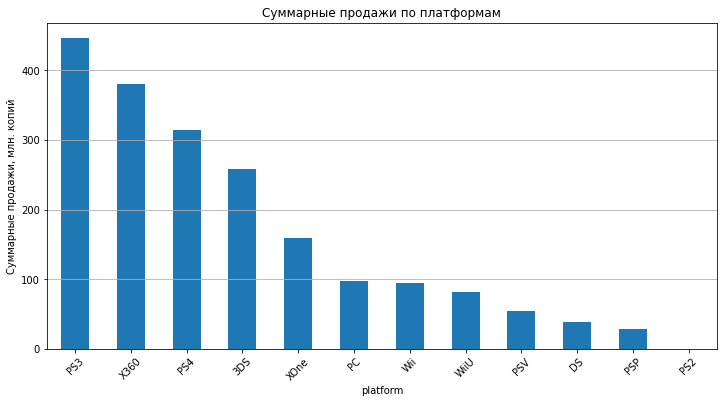

In [15]:
# группируем данные по платформам и суммарным продажам
platform_sales = actual_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

# визуализируем
plt.figure(figsize=(12, 6))
platform_sales.plot(kind='bar')
plt.title('Суммарные продажи по платформам')
plt.ylabel('Суммарные продажи, млн. копий')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


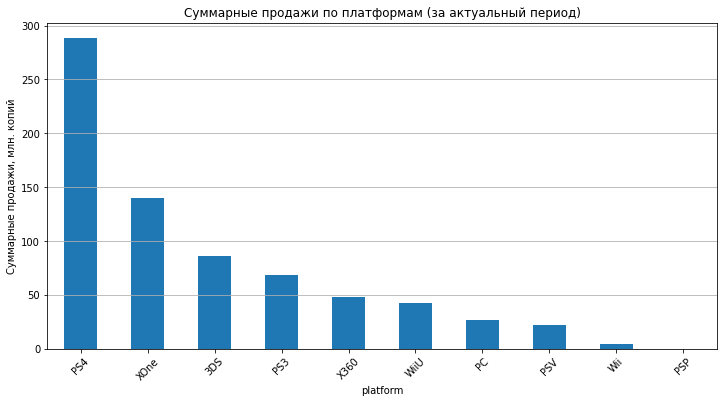

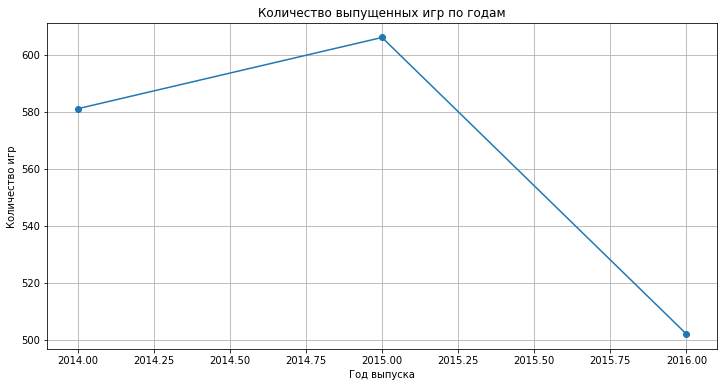

In [46]:
#  группируем данные по платформам и суммарным продажам за актуальный период
platform_sales = actual_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

# визуализируем
plt.figure(figsize=(12, 6))
platform_sales.plot(kind='bar')
plt.title('Суммарные продажи по платформам (за актуальный период)')
plt.ylabel('Суммарные продажи, млн. копий')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# группируем данные по годам выпуска и подсчитываем количество игр для актуального периода
games_per_year = actual_data.groupby('year_of_release')['name'].count()

# визуализируем
plt.figure(figsize=(12, 6))
games_per_year.plot(kind='line', marker='o', linestyle='-')
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.grid(True)
plt.show()


Мы видим что за актуальный период, максимальное выпущенное количество игр было выпущено в 2015 году.

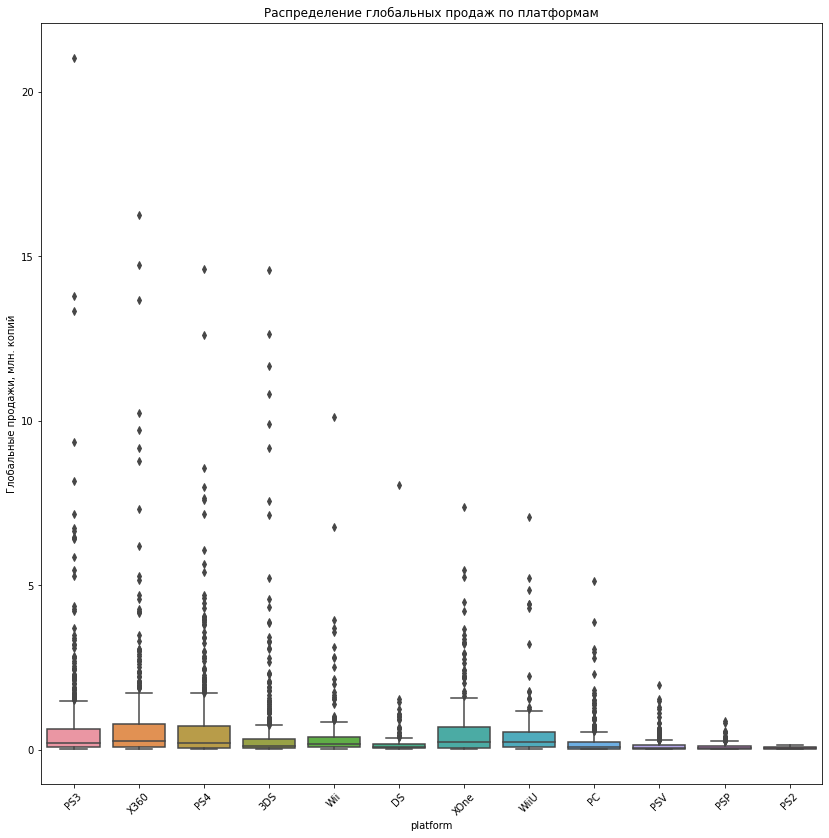

In [46]:
# построим "ящик с усами" для глобальных продаж по платформам за актуальный период
#plt.figure(figsize=(14, 14))
#sns.boxplot(x='platform', y='total_sales', data=actual_data)
#plt.title('Распределение глобальных продаж по платформам')
#plt.ylabel('Глобальные продажи, млн. копий')
#plt.xticks(rotation=45)
#plt.show()


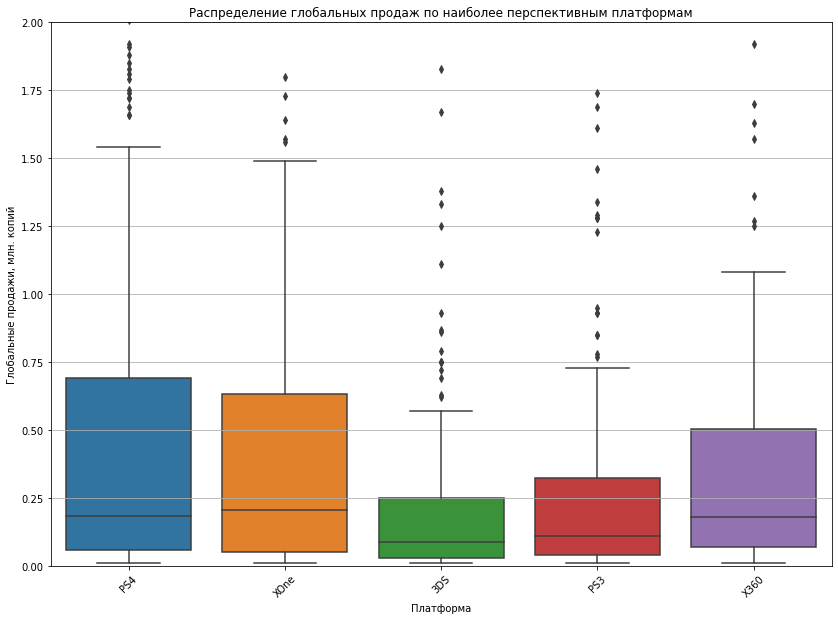

In [32]:
# выбор наиболее перспективных платформ за актуальный период
top_platforms_actual = actual_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index

# построим "ящик с усами" для глобальных продаж по выбранным платформам
plt.figure(figsize=(14, 10))
sns.boxplot(x='platform', y='total_sales', data=actual_data[actual_data['platform'].isin(top_platforms_actual)], order=top_platforms_actual)
plt.title('Распределение глобальных продаж по наиболее перспективным платформам')
plt.ylabel('Глобальные продажи, млн. копий')
plt.xlabel('Платформа')
plt.xticks(rotation=45)
plt.ylim(0, 2)
plt.grid(axis='y')
plt.show()


Глядя на суммарные продажи по каждой платформе, возьмем платформу PS4 и посмотрим как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.

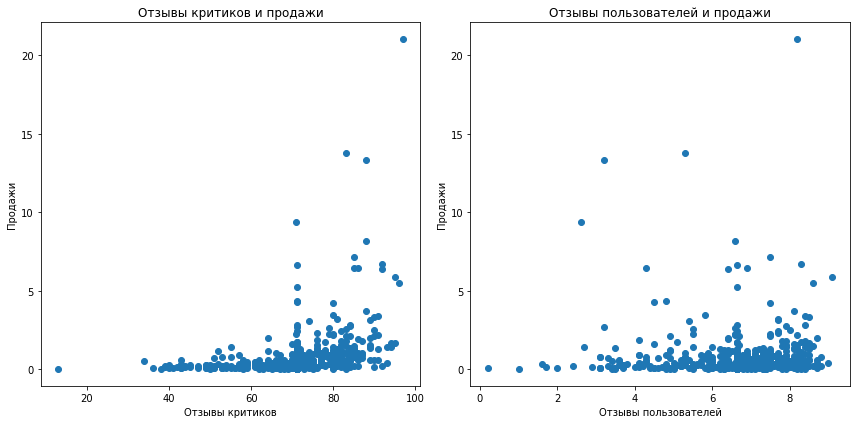

Корреляция между отзывами критиков и продажами: 0.34652359860950155
Корреляция между отзывами пользователей и продажами: 0.011166947806239414


In [30]:
ps3_data = actual_data[actual_data['platform'] == 'PS3']
plt.figure(figsize=(12, 6))
# диаграмма рассеивания для отзывов критиков и продаж
plt.subplot(1, 2, 1)
plt.scatter(ps3_data['critic_score'], ps3_data['total_sales'])
plt.title('Отзывы критиков и продажи')
plt.xlabel('Отзывы критиков')
plt.ylabel('Продажи')

# диаграмма рассеивания для отзывов пользователей и продаж
plt.subplot(1, 2, 2)
plt.scatter(ps3_data['user_score'], ps3_data['total_sales'])
plt.title('Отзывы пользователей и продажи')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')

plt.tight_layout()
plt.show()

# корреляция между отзывами критиков и продажами
critic_corr = ps3_data['critic_score'].corr(ps3_data['total_sales'])

# корреляция между отзывами пользователей и продажами
user_corr = ps3_data['user_score'].corr(ps3_data['total_sales'])

print("Корреляция между отзывами критиков и продажами:", critic_corr)
print("Корреляция между отзывами пользователей и продажами:", user_corr)


Корреляция между отзывами критиков и продажами составляет приблизительно 0.35, что указывает на наличие некоторой положительной корреляции. Это может означать, что игры с более высокими оценками от критиков склонны иметь более высокие продажи.
В то время как, корреляция между отзывами пользователей и продажами очень низкая, практически равна нулю. Это может означать, что мнение пользователей не оказывает значительного влияния на продажи игр, по крайней мере, на платформе PS3.
Следовательно, для платформы PS3 отзывы критиков имеют большее значение для прогнозирования продаж игр, чем мнение пользователей.

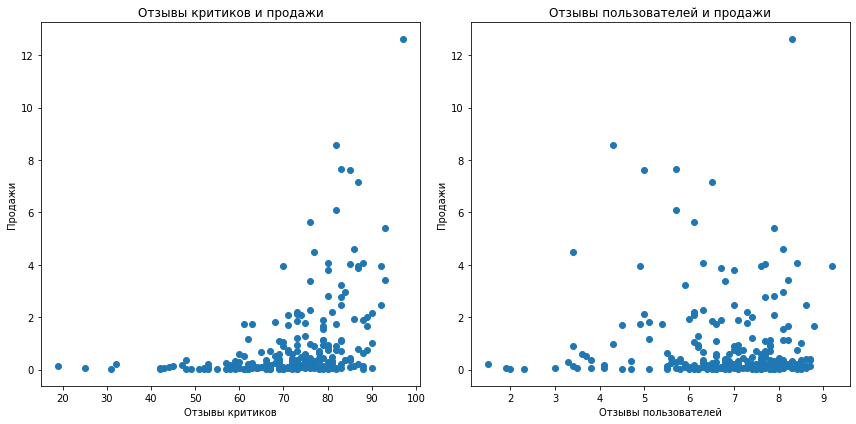

Корреляция между отзывами критиков и продажами: 0.40266141068104083
Корреляция между отзывами пользователей и продажами: -0.040131589472697356


In [34]:
ps4_data = actual_data[actual_data['platform'] == 'PS4']
plt.figure(figsize=(12, 6))
# диаграмма рассеивания для отзывов критиков и продаж
plt.subplot(1, 2, 1)
plt.scatter(ps4_data['critic_score'], ps4_data['total_sales'])
plt.title('Отзывы критиков и продажи')
plt.xlabel('Отзывы критиков')
plt.ylabel('Продажи')

# диаграмма рассеивания для отзывов пользователей и продаж
plt.subplot(1, 2, 2)
plt.scatter(ps4_data['user_score'], ps4_data['total_sales'])
plt.title('Отзывы пользователей и продажи')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')

plt.tight_layout()
plt.show()

# корреляция между отзывами критиков и продажами
critic_corr = ps4_data['critic_score'].corr(ps4_data['total_sales'])

# корреляция между отзывами пользователей и продажами
user_corr = ps4_data['user_score'].corr(ps4_data['total_sales'])

print("Корреляция между отзывами критиков и продажами:", critic_corr)
print("Корреляция между отзывами пользователей и продажами:", user_corr)


Глядя на графики для платформы PS4 мы можем сделать такой же вывод, что игры с более высокими оценками от критиков склонны иметь более высокие продажи. В то время как, корреляция между отзывами пользователей и продажами очень низкая, практически равна нулю. Это может означать, что мнение пользователей не оказывает значительного влияния на продажи игр

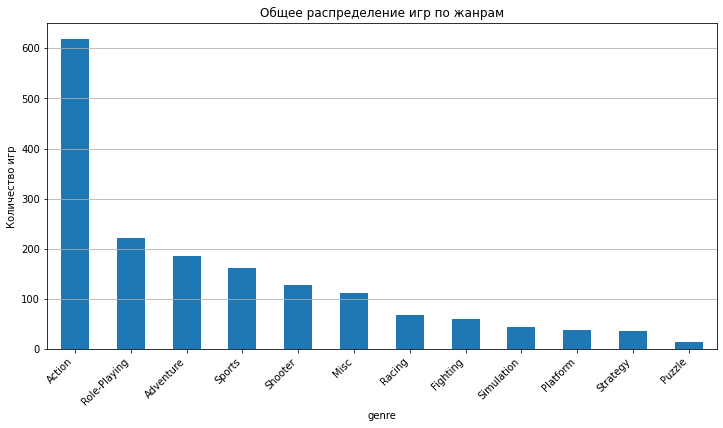

In [40]:
# посмотрим на общее распределение игр по жанрам
# меняю данные и беру только данные за актуальный период
genre_counts = actual_data.groupby('genre')['name'].count().sort_values(ascending=False)

# визуализируем
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Общее распределение игр по жанрам')
plt.ylabel('Количество игр')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

Глядя на график, мы видим что наибольшее количество игр идут в жанре Action

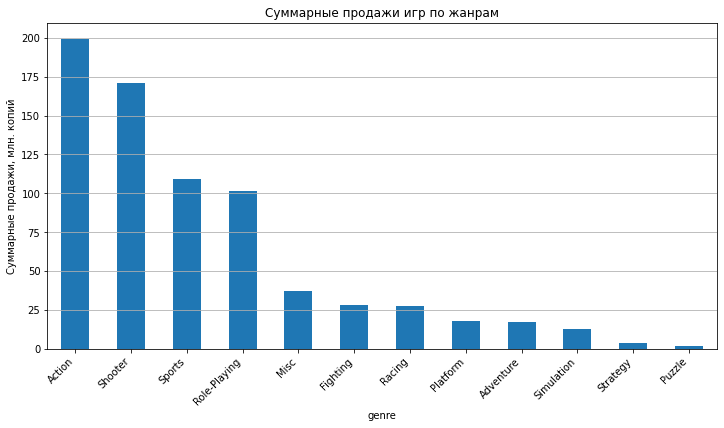

In [38]:
# посмотрим на общие суммарные продажи для каждого жанра
# меняю данные и беру только данные за актуальный период
genre_sales = actual_data.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

# вмзуализируем
plt.figure(figsize=(12, 6))
genre_sales.plot(kind='bar')
plt.title('Суммарные продажи игр по жанрам')
plt.ylabel('Суммарные продажи, млн. копий')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


Из графика видно, что самые прибыльные жанры это Action и Shooter

Проанализируем различия между жанрами с высокими и низкими продажами.

Для этого, сравним средние продажи игр для каждого жанра. Мы возьмем медианное значение продаж как меру средних продаж, так как оно более устойчиво к выбросам. 

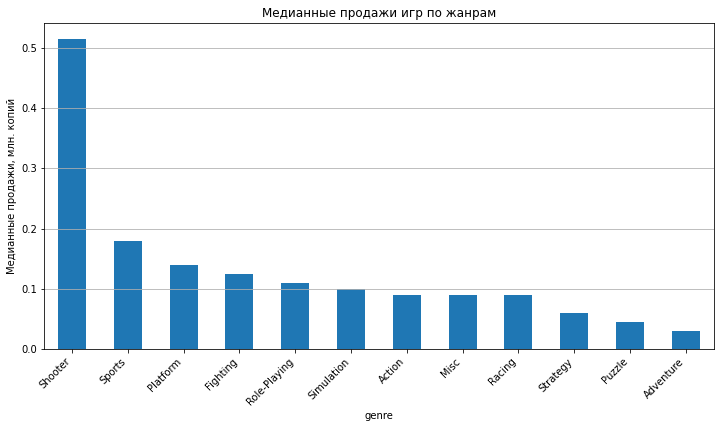

In [35]:
# группируем данные по жанрам и посчитаем медианные продажи для каждого жанра
# меняю данные и беру только данные за актуальный период
genre_median_sales = actual_data.groupby('genre')['total_sales'].median().sort_values(ascending=False)

# визуализируем
plt.figure(figsize=(12, 6))
genre_median_sales.plot(kind='bar')
plt.title('Медианные продажи игр по жанрам')
plt.ylabel('Медианные продажи, млн. копий')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


Глядя на медианное значение продаж, видно что жанр Platform на первом месте, в то время как Adventure на последнем. Хотя по суммарным продажам жанр Action был на первом, а Strategy на последнем.

#### Шаг 4. Составьте портрет пользователя каждого региона

In [41]:
# самые популярные платформы (топ-5) в каждом регионе
# меняю данные и беру только данные за актуальный период
top_platforms_na = actual_data.groupby('platform')['na_sales'].sum().nlargest(5)
top_platforms_eu = actual_data.groupby('platform')['eu_sales'].sum().nlargest(5)
top_platforms_jp = actual_data.groupby('platform')['jp_sales'].sum().nlargest(5)

# самые популярные жанры (топ-5) в каждом регионе
# меняю данные и беру только данные за актуальный период
top_genres_na = actual_data.groupby('genre')['na_sales'].sum().nlargest(5)
top_genres_eu = actual_data.groupby('genre')['eu_sales'].sum().nlargest(5)
top_genres_jp = actual_data.groupby('genre')['jp_sales'].sum().nlargest(5)

# влияние рейтинга ESRB на продажи в отдельном регионе
# меняю данные и беру только данные за актуальный период
esrb_sales_na = actual_data.groupby('rating')['na_sales'].mean()
esrb_sales_eu = actual_data.groupby('rating')['eu_sales'].mean()
esrb_sales_jp = actual_data.groupby('rating')['jp_sales'].mean()

# выводим
print("Самые популярные платформы в Северной Америке:")
print(top_platforms_na)
print("\nСамые популярные платформы в Европе:")
print(top_platforms_eu)
print("\nСамые популярные платформы в Японии:")
print(top_platforms_jp)

print("\nСамые популярные жанры в Северной Америке:")
print(top_genres_na)
print("\nСамые популярные жанры в Европе:")
print(top_genres_eu)
print("\nСамые популярные жанры в Японии:")
print(top_genres_jp)

print("\nСредние продажи в Северной Америке по рейтингу ESRB:")
print(esrb_sales_na)
print("\nСредние продажи в Европе по рейтингу ESRB:")
print(esrb_sales_eu)
print("\nСредние продажи в Японии по рейтингу ESRB:")
print(esrb_sales_jp)


Самые популярные платформы в Северной Америке:
platform
PS4     98.61
XOne    81.27
X360    28.30
3DS     22.64
PS3     22.05
Name: na_sales, dtype: float64

Самые популярные платформы в Европе:
platform
PS4     130.04
XOne     46.25
PS3      25.54
PC       17.97
3DS      16.12
Name: eu_sales, dtype: float64

Самые популярные платформы в Японии:
platform
3DS     44.24
PS4     15.02
PSV     14.54
PS3     11.22
WiiU     7.31
Name: jp_sales, dtype: float64

Самые популярные жанры в Северной Америке:
genre
Shooter         79.02
Action          72.53
Sports          46.13
Role-Playing    33.47
Misc            15.05
Name: na_sales, dtype: float64

Самые популярные жанры в Европе:
genre
Action          74.68
Shooter         65.52
Sports          45.73
Role-Playing    28.17
Racing          14.13
Name: eu_sales, dtype: float64

Самые популярные жанры в Японии:
genre
Role-Playing    31.16
Action          29.58
Fighting         6.37
Misc             5.61
Shooter          4.87
Name: jp_sales, dtyp

Так как мы теперь взяли данные за актуальный период, результат поменялся. 

В Северной Америке и Европе наиболее популярны PlayStation 4 (PS4) и Xbox One (XOne), в то время как в Японии популярностью пользуется Nintendo 3DS (3DS).
Очевидно, что предпочтения в выборе игровых платформ существенно различаются в разных регионах.

В Северной Америке и Европе наибольшей популярностью пользуются игры жанра Shooter и Action, в то время как в Японии предпочтение отдается Role-Playing и Action играм.
Также отмечается разнообразие предпочтений в жанрах игр между регионами.

В Северной Америке и Европе лучшие продажи у игр с рейтингом "M" (Mature) - для взрослых, в то время как в Японии наиболее популярны игры с рейтингом "T" (Teen) - для подростков.

Исходя из предоставленного вывода, можно сделать следующие выводы:

Самые популярные платформы в разных регионах:

Северная Америка: Xbox 360 (602.47 млн), PS2 (583.84 млн), Wii (496.90 млн)
Европа: PS2 (339.29 млн), PS3 (330.29 млн), Xbox 360 (270.76 млн)
Япония: DS (175.57 млн), PS (139.82 млн), PS2 (139.20 млн)
Различия в популярных платформах могут быть обусловлены особенностями предпочтений и рынка в каждом регионе.

Самые популярные жанры в разных регионах:

Северная Америка: Action (879.01 млн), Sports (684.43 млн), Shooter (592.24 млн)
Европа: Action (519.13 млн), Sports (376.79 млн), Shooter (317.34 млн)
Япония: Role-Playing (355.41 млн), Action (161.43 млн), Sports (135.54 млн)
В Японии жанр Role-Playing является самым популярным, что отражает предпочтение игр с интересным сюжетом и разнообразными персонажами.

Влияние рейтинга ESRB на продажи в отдельном регионе:

В Северной Америке и Европе наибольшие продажи приходятся на игры с рейтингом E (Everyone) и M (Mature), в то время как в Японии наиболее популярны игры с рейтингом E и K-A (Kids to Adults).
Возможно, это связано с культурными различиями и предпочтениями аудитории в разных региона.

#### Шаг 5. Проверьте гипотезы

Формулировка гипотез:

Гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC:

H0: Средние пользовательские рейтинги платформ Xbox One и PC равны.
H1: Средние пользовательские рейтинги платформ Xbox One и PC различаются.

Гипотеза о различии средних пользовательских рейтингов жанров Action и Sports:

H0: Средние пользовательские рейтинги жанров Action и Sports одинаковы.
H1: Средние пользовательские рейтинги жанров Action и Sports различаются.

In [66]:
# гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC
xbox_one_ratings = games[games['platform'] == 'XOne']['user_score'].dropna()
pc_ratings = games[games['platform'] == 'PC']['user_score'].dropna()

alpha = 0.05  # Уровень статистической значимости

results_platforms = stats.ttest_ind(xbox_one_ratings, pc_ratings)
print("p-value:", results_platforms.pvalue)

if results_platforms.pvalue < alpha:
    print("Отвергаем нулевую гипотезу") # средние пользовательские рейтинги платформ Xbox One и PC различаются
else:
    print("Не получилось отвергнуть нулевую гипотезу") # средние пользовательские рейтинги платформ Xbox One и PC одинаковы

# гипотеза о различии средних пользовательских рейтингов жанров Action и Sports
action_ratings = games[games['genre'] == 'Action']['user_score'].dropna()
sports_ratings = games[games['genre'] == 'Sports']['user_score'].dropna()

results_genres = stats.ttest_ind(action_ratings, sports_ratings)
print("p-value:", results_genres.pvalue)

if results_genres.pvalue < alpha:
    print("Отвергаем нулевую гипотезу") # средние пользовательские рейтинги жанров Action и Sports различаются
else:
    print("Не получилось отвергнуть нулевую гипотезу") # средние пользовательские рейтинги жанров Action и Sports одинаковы


p-value: 1.3896435533548819e-05
Отвергаем нулевую гипотезу
p-value: 0.10406951359049141
Не получилось отвергнуть нулевую гипотезу


Для проверки гипотез мы используем t-тест так как у нас есть две независимые выборки пользовательских рейтингов (Xbox One и PC, жанры Action и Sports), и мы хотим определить, есть ли статистически значимые различия между средними рейтингами этих групп.

В результате теста:
Для гипотезы о равенстве средних пользовательских рейтингов платформ Xbox One и PC вы получили p-value равное 1.3896435533548819e-05, что значительно меньше выбранного порогового значения alpha (0.05). Поэтому мы отвергаем нулевую гипотезу и делаем вывод о том, что средние пользовательские рейтинги платформ Xbox One и PC различаются.

Для гипотезы о различии средних пользовательских рейтингов жанров Action и Sports получили p-value равное 0.10406951359049141, что больше выбранного порогового значения alpha (0.05). Это означает, что у нас недостаточно данных, чтобы отвергнуть нулевую гипотезу. Следовательно, мы не можем сделать вывод о различии средних пользовательских рейтингов жанров Action и Sports на основе имеющихся данных.

#### Шаг 6. Напишите общий вывод


В ходе выполнения проекта был проведен обширный анализ данных интернет-магазина "Стримчик", специализирующегося на продаже компьютерных игр.
Проект состоял из нескольких этапов:

* Открытие файла и изучение общей информации: В начале проекта мы ознакомились с данными, выявили основные структуры и проблемы, требующие предобработки.

* Предобработка данных: Мы провели предобработку данных, включающую в себя обработку пропущенных значений, преобразование типов данных и обработку дубликатов.

* Исследовательский анализ данных: Проведен анализ данных, включающий определение актуального периода, выявление популярных платформ и жанров, а также оценку влияния рейтинга ESRB на продажи игр.

* Портрет пользователя каждого региона: Мы определили основные предпочтения пользователей в разных регионах (Северная Америка, Европа, Япония) по платформам, жанрам и рейтингам ESRB.

* Проверка гипотез: Были проверены две гипотезы о равенстве средних пользовательских рейтингов для платформ Xbox One и PC, а также о различии средних пользовательских рейтингов для жанров Action и Sports.

На основе проведенного анализа мы сделали следующие выводы:

В Северной Америке наиболее популярными платформами оказались Xbox 360, PS2 и Wii, а самыми востребованными жанрами являются Action, Sports и Shooter. Здесь наибольшее влияние на продажи оказывают игры с рейтингами E (Everyone) и M (Mature).
В Европе сценарий немного отличается: здесь PS2, PS3 и Xbox 360 становятся лидерами по популярности, а в списке популярных жанров оказываются также Action, Sports и Shooter. Похожие на Североамериканский рейтинги E и M также оказывают большое влияние на продажи.
В Японии предпочтения снова отличаются: здесь наиболее популярны DS, PS и PS2, а жанр Role-Playing стоит во главе списка предпочтений. Рейтинги E и K-A наиболее востребованы в этом регионе.
Эти различия могут быть обусловлены как культурными особенностями, так и особенностями рынка и доступности различных игровых платформ.
Отзывы критиков оказывают большее влияние на продажи игр, чем мнения пользователей.
Рейтинг ESRB также имеет значительное влияние на продажи игр в различных регионах.
Эти выводы могут быть использованы интернет-магазином "Стримчик" для оптимизации стратегий маркетинга, ассортимента продукции и общего планирования бизнеса.
